In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score, 
    precision_recall_fscore_support
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Preliminary Data Exploration

In [29]:
import pandas as pd

# Load the CSV
df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

print(f"Total unfiltered rows: {df.shape[0]}")

# Filter out rows with nulls in necessary columns
filtered = df[
    df["victim_age"].notna() &
    df["victim_sex"].notna() &
    df["victim_descent"].notna() &
    df["crime_code"].notna() &
    df["latitude"].notna() &
    df["longitude"].notna() &
    df["area"].notna() & 
    df["premise_code"].notna() &
    (df["victim_age"].astype(str).str.strip() != "") &
    (df["victim_sex"].astype(str).str.strip() != "") &
    (df["victim_descent"].astype(str).str.strip() != "")
]

# Compute counts for filtered data
total_rows = filtered.shape[0]
unique_districts = filtered["reporting_district"].nunique()
unique_crime_codes = filtered["crime_code"].nunique()

print(f"Total filtered rows: {total_rows}")
print(f"Unique reporting_district: {unique_districts}")
print(f"Unique crime_code (before filtering): {unique_crime_codes}")

# Calculate relative frequency of each crime_code
code_freq = filtered["crime_code"].value_counts(normalize=True)

# Identify codes accounting for < 1% of filtered rows
low_freq_codes = code_freq[code_freq < 0.01].index.tolist()
print(f"Number of crime_codes < 1% frequency: {len(low_freq_codes)}")

# Filter out those low-frequency crime_codes
filtered_no_rare = filtered[~filtered["crime_code"].isin(low_freq_codes)]

# Print before/after row counts
print(f"Rows before removing rare codes: {total_rows}")
print(f"Rows after removing rare codes: {filtered_no_rare.shape[0]}")

# Print unique crime codes after filtering
print(f"Unique crime_code (after filtering): {filtered_no_rare['crime_code'].nunique()}")

# Calculate percentage share of each remaining crime_code
crime_pct = (
    filtered_no_rare["crime_code"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .rename_axis("crime_code")
    .reset_index(name="percentage")
)

print(crime_pct)

# Number of unique weapon_codes
unique_weapon_codes = filtered_no_rare["weapon_code"].nunique()
print(f"Unique weapon_code count: {unique_weapon_codes}")

# Percentage share of each weapon_code
weapon_pct = (
    filtered_no_rare["weapon_code"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .rename_axis("weapon_code")
    .reset_index(name="percentage")
)

print(weapon_pct)

# Count weapon_codes that account for > 1% of filtered_no_rare rows
high_freq_weapons = weapon_pct[weapon_pct["percentage"] > 1.0]
print(f"Number of weapon_codes > 1%: {high_freq_weapons.shape[0]}")

# Number of unique premise_codes
unique_premise_codes = filtered_no_rare["premise_code"].nunique()
print(f"Unique premise_code count: {unique_premise_codes}")

# Percentage share of each premise_code
premise_pct = (
    filtered_no_rare["premise_code"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .rename_axis("premise_code")
    .reset_index(name="percentage")
)

print(premise_pct)

# Count premise_codes that account for > 1% of filtered_no_rare rows
high_freq_premises = premise_pct[premise_pct["percentage"] > 1.0]
print(f"Number of premise_codes > 1%: {high_freq_premises.shape[0]}")

# Print the frequency of the non-rare crimes
crime_description_counts = filtered_no_rare["crime_description"].value_counts()
print("\nFrequency of each crime description (in descending order):")
print(crime_description_counts)

Total unfiltered rows: 852950
Total filtered rows: 740331
Unique reporting_district: 1196
Unique crime_code (before filtering): 137
Number of crime_codes < 1% frequency: 118
Rows before removing rare codes: 740331
Rows after removing rare codes: 623833
Unique crime_code (after filtering): 19
    crime_code  percentage
0          624       10.89
1          354        8.56
2          330        8.43
3          310        8.32
4          740        8.30
5          230        7.83
6          440        6.95
7          626        6.85
8          331        4.92
9          210        4.68
10         341        4.44
11         745        3.62
12         442        3.31
13         930        2.83
14         420        2.40
15         761        2.12
16         888        1.97
17         236        1.86
18         901        1.72
Unique weapon_code count: 79
    weapon_code  percentage
0         400.0       53.09
1         500.0       10.57
2         511.0        7.59
3         102.0        6.0

# Data Cleaning / Feature Engineering

In [3]:
# Load the CSV
df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

# Transform the 'part' column to 'serious_crime'
df['serious_crime'] = df['part'].apply(lambda x: 1 if x == 1 else 0)
df = df.drop(columns=['part'])

# Remove rows where victim_age, victim_sex, victim_descent, latitude, longitude, or area is null.
required_cols = ['victim_age', 'victim_sex', 'victim_descent', 'latitude', 'longitude', 'area', 'crime_code', 'premise_code']
df = df.dropna(subset=required_cols)

df = df.drop_duplicates()
print(

# Remove any empty strings.
df = df[df['victim_sex'].str.strip() != '']
df = df[df['victim_descent'].str.strip() != '']

# Remove rows where victim_age is 0 or victim_sex/victim_descent equal "X".
df = df[df['victim_age'] != 0]
df = df[(df['victim_sex'] != 'X') & (df['victim_descent'] != 'X')]

# Filter to only include the top 10 most common crime_code values.
top10_crime_codes = df['crime_code'].value_counts().nlargest(10).index
df = df[df['crime_code'].isin(top10_crime_codes)]

# Filter to keep only rows with the top 10 most frequent weapon_code, top 10 premise_code, and top 10 area values.
top10_weapon_codes = df['weapon_code'].value_counts().nlargest(10).index
top10_premise_codes = df['premise_code'].value_counts().nlargest(10).index
df = df[df['weapon_code'].isin(top10_weapon_codes) & df['premise_code'].isin(top10_premise_codes)]
top10_areas = df['area'].value_counts().nlargest(10).index
df = df[df['area'].isin(top10_areas)]

# Drop unnecessary columns.
cols_to_drop = [
    'division_number', 'date_reported', 'date_occurred', 'modus_operandi',
    'status', 'status_description', 'crime_code_1', 'crime_code_2',
    'crime_code_3', 'crime_code_4', 'location', 'cross_street', 'reporting_district'
]
df = df.drop(columns=cols_to_drop)

# Store original mappings of categorical variables.
weapon_map_orig = df[['weapon_code', 'weapon_description']].drop_duplicates()
premise_map_orig = df[['premise_code', 'premise_description']].drop_duplicates()
area_map_orig    = df[['area', 'area_name']].drop_duplicates()
crime_map_orig   = df[['crime_code', 'crime_description']].drop_duplicates()

# Coordinates of the center of the city of Los Angeles.
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

# https://community.esri.com/t5/coordinate-reference-systems-blog/distance-on-a-sphere-the-haversine-formula/ba-p/902128#:~:text=For%20example%2C%20haversine(θ),longitude%20of%20the%20two%20points.
# This function is used to find the distance in km between two coordinates.
def haversine(lat1, lon1, lat2, lon2):
    # convert all angles to radians
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    
    dlat = lat1 - lat2
    dlon = lon1 - lon2
    
    a = np.sin(dlat/2)**2 + np.cos(lat2) * np.cos(lat1) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    R = 6371.0  # earth radius in km
    return c * R

# Feature Engineering the dist_from_center statistic
df['dist_from_center'] = haversine(
    df['latitude'],
    df['longitude'],
    center_lat,
    center_lon
)

# Remap the categorical codes to continuous integers.
def create_mapping(series):
    # Create a mapping from each unique value to an integer starting at 0.
    unique_vals = sorted(series.dropna().unique())
    return {val: int(i) for i, val in enumerate(unique_vals)}

crime_code_dict   = create_mapping(df['crime_code'])
weapon_code_dict  = create_mapping(df['weapon_code'])
premise_code_dict = create_mapping(df['premise_code'])
area_dict         = create_mapping(df['area'])

# Apply the new mappings to dataset.
df['crime_code']   = df['crime_code'].map(crime_code_dict).astype(int)
df['weapon_code']  = df['weapon_code'].map(weapon_code_dict).astype(int)
df['premise_code'] = df['premise_code'].map(premise_code_dict).astype(int)
df['area']         = df['area'].map(area_dict).astype(int)

# Change the original codes mappings to the new code mappings.

# For crime:
crime_mapping = crime_map_orig.drop_duplicates(subset=['crime_code']).copy()
crime_mapping['crime_code'] = crime_mapping['crime_code'].map(crime_code_dict)
crime_mapping = crime_mapping[['crime_code', 'crime_description']]
crime_mapping = crime_mapping.dropna(subset=['crime_code', 'crime_description'])
crime_mapping['crime_code'] = crime_mapping['crime_code'].astype(int)

# Combine simple assault and theft from vehicle into one group.
simple_assault_group = ["BATTERY - SIMPLE ASSAULT", "INTIMATE PARTNER - SIMPLE ASSAULT"]

# Combine simple assault and theft from vehicle into one group.
theft_vehicle_group = ["THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)", "BURGLARY FROM VEHICLE"]

# Identify old crime codes (after remapping) for each group.
simple_assault_codes = crime_mapping[crime_mapping['crime_description'].isin(simple_assault_group)]['crime_code'].unique().tolist()
theft_vehicle_codes = crime_mapping[crime_mapping['crime_description'].isin(theft_vehicle_group)]['crime_code'].unique().tolist()

# Choose a unified crime code for each group; here, we take the minimum code in each group.
if simple_assault_codes:
    unified_simple_assault_code = min(simple_assault_codes)
if theft_vehicle_codes:
    unified_theft_vehicle_code = min(theft_vehicle_codes)

# Update the df to reassign crime_code for rows in these groups.
df.loc[df['crime_code'].isin(simple_assault_codes), 'crime_code'] = unified_simple_assault_code
df.loc[df['crime_code'].isin(theft_vehicle_codes), 'crime_code'] = unified_theft_vehicle_code

# Remove the old mappings that belong to these groups.
crime_mapping = crime_mapping[~crime_mapping['crime_code'].isin(simple_assault_codes + theft_vehicle_codes)]
# Append new unified mapping rows.
if simple_assault_codes:
    crime_mapping = pd.concat([crime_mapping, pd.DataFrame({
        'crime_code': [unified_simple_assault_code],
        'crime_description': ['SIMPLE ASSAULT']
    })], ignore_index=True)
if theft_vehicle_codes:
    crime_mapping = pd.concat([crime_mapping, pd.DataFrame({
        'crime_code': [unified_theft_vehicle_code],
        'crime_description': ['THEFT FROM VEHICLE']
    })], ignore_index=True)


# Continue making new mappings for categorical variables:

# For weapon:
weapon_mapping = weapon_map_orig.drop_duplicates(subset=['weapon_code']).copy()
weapon_mapping['weapon_code'] = weapon_mapping['weapon_code'].map(weapon_code_dict)
weapon_mapping = weapon_mapping[['weapon_code', 'weapon_description']]
weapon_mapping = weapon_mapping.dropna(subset=['weapon_code', 'weapon_description'])
weapon_mapping['weapon_code'] = weapon_mapping['weapon_code'].astype(int)

# For premise:
premise_mapping = premise_map_orig.drop_duplicates(subset=['premise_code']).copy()
premise_mapping['premise_code'] = premise_mapping['premise_code'].map(premise_code_dict)
premise_mapping = premise_mapping[['premise_code', 'premise_description']]
premise_mapping = premise_mapping.dropna(subset=['premise_code', 'premise_description'])
premise_mapping['premise_code'] = premise_mapping['premise_code'].astype(int)

# For area:
area_mapping = area_map_orig.drop_duplicates(subset=['area']).copy()
area_mapping['area_code'] = area_mapping['area'].map(area_dict)
area_mapping = area_mapping[['area_code', 'area_name']]
area_mapping = area_mapping.dropna(subset=['area_code', 'area_name'])
area_mapping['area_code'] = area_mapping['area_code'].astype(int)

# One-hot encode the categorical columns.

# Ensure weapon code is an integer before one-hot encoding. It is a float for some reason in the original dataset.
df['weapon_code'] = df['weapon_code'].astype(int)

# One-hot encode the categorical columns.
df = pd.get_dummies(df, columns=['weapon_code', 'premise_code', 'area'],
                            prefix=['weapon', 'premise', 'area'])

# Remove outliers in the'dist_from_center' column using the IQR method.
Q1 = df['dist_from_center'].quantile(0.25)
Q3 = df['dist_from_center'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['dist_from_center'] >= lower_bound) & (df['dist_from_center'] <= upper_bound)]

# Normalize the distance to range [0, 1].
min_distance = df['dist_from_center'].min()
max_distance = df['dist_from_center'].max()
df['norm_distance'] = (df['dist_from_center'] - min_distance) / (max_distance - min_distance)

# Compute the angle from the center.
df['delta_lat'] = df['latitude'] - center_lat
df['delta_lon'] = df['longitude'] - center_lon
df['angle'] = np.arctan2(df['delta_lon'], df['delta_lat'])
# Shift angle from [-pi, pi] to [0, 2pi] and then normalize.
df['norm_angle'] = (df['angle'] + np.pi) / (2 * np.pi)

# Drop unnecessary coordinate columns.
df = df.drop(columns=['latitude', 'longitude', 'delta_lat', 'delta_lon', 'angle', 'dist_from_center'])

# Normalize victim_age to range [0, 1].
min_age = df['victim_age'].min()
max_age = df['victim_age'].max()
df['victim_age'] = (df['victim_age'] - min_age) / (max_age - min_age)

# Map victim_sex to binary: "M" to 1 and "F" to 0.
df['victim_sex'] = df['victim_sex'].map({'M': 1, 'F': 0})
df = df.dropna(subset=['victim_sex'])
df['victim_sex'] = df['victim_sex'].astype(int)

# Filter to include only the allowed victim_descent codes (These are the ones that constitute the majority of the data).
allowed_descent = ['A', 'B', 'H', 'O', 'W']
df = df[df['victim_descent'].isin(allowed_descent)]

# Create a mapping for the allowed descent codes and their full names.
descent_map = {
    'A': 'Asian',
    'B': 'Black',
    'H': 'Hispanic',
    'O': 'Other',
    'W': 'White'
}

# Save the descent mapping as a CSV.
descent_mapping = pd.DataFrame({
    'descent_code': list(descent_map.keys()),
    'descent_description': list(descent_map.values())
})

# One-hot encode the victim_descent column.
df = pd.get_dummies(df, columns=['victim_descent'], prefix='victim_descent')

# Drop description columns as they are now in the mapping CSVs.
df = df.drop(columns=['weapon_description', 'premise_description', 'area_name', 'crime_description'])

# Convert boolean columns to integers.
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

# Remove crime codes with less than 500 occurrences.
crime_freq = df['crime_code'].value_counts()
valid_crime_codes = crime_freq[crime_freq >= 500].index.tolist()
df = df[df['crime_code'].isin(valid_crime_codes)]
# Update crime_mapping accordingly.
crime_mapping = crime_mapping[crime_mapping['crime_code'].isin(valid_crime_codes)]

# Filter out categorical columns with less than 150 occurrences.
def filter_categorical_columns(df, prefix, mapping_df, mapping_col):
    # Get list of dummy column names with this prefix.
    dummy_cols = [col for col in df.columns if col.startswith(prefix + "_")]
    # Sum up the ones in each column.
    counts = df[dummy_cols].sum()
    # Keep only the columns with count >= 150.
    valid_cols = counts[counts >= 150].index.tolist()
    # Drop the columns that are not valid.
    to_drop = set(dummy_cols) - set(valid_cols)
    df = df.drop(columns=list(to_drop))
    # Update mapping_df: extract valid numeric code from valid_cols.
    valid_codes = [int(col.split('_')[1]) for col in valid_cols]
    mapping_df = mapping_df[mapping_df[mapping_col].isin(valid_codes)]
    return df, mapping_df

df, weapon_mapping = filter_categorical_columns(df, "weapon", weapon_mapping, "weapon_code")
df, premise_mapping = filter_categorical_columns(df, "premise", premise_mapping, "premise_code")
df, area_mapping = filter_categorical_columns(df, "area", area_mapping, "area_code")

# Limit the number of samples for each crime code to 3000 to keep balance.
samples_list = []
for code, group in df.groupby('crime_code'):
    if len(group) >= 3000:
        sample = group.sample(n=3000, random_state=42)
    else:
        sample = group
    samples_list.append(sample)
df = pd.concat(samples_list)
df = df.copy()

# Get sorted list of remaining codes.
final_codes = sorted(df['crime_code'].unique())
# Remap the crime_codes one more time so they are continuous integers from 0.
final_code_dict = {old: new for new, old in enumerate(final_codes)}

# Apply it to df.
df['crime_code'] = df['crime_code'].map(final_code_dict).astype(int)

# Update crime_mapping to use the new codes.
crime_mapping['crime_code'] = crime_mapping['crime_code'].map(final_code_dict).astype(int)
crime_mapping = crime_mapping.sort_values('crime_code').reset_index(drop=True)

# Write all dataframes to files for easy loading later if necessary.
df.to_csv("cleaned_crime_data_stratified.csv", index=False)
weapon_mapping.to_csv("weapon_mapping.csv", index=False)
premise_mapping.to_csv("premise_mapping.csv", index=False)
area_mapping.to_csv("area_mapping.csv", index=False)
crime_mapping.to_csv("crime_mapping.csv", index=False)
descent_mapping.to_csv("descent_mapping.csv", index=False)

# Print some statistics
total_rows = df.shape[0]
print(f"Total filtered rows: {total_rows}")
print(f"Unique crime codes (after remapping, combining, sampling, and filtering): {df['crime_code'].nunique()}")
print(f"Unique weapon codes (after remapping): {len(weapon_code_dict)}")
print(f"Unique premise codes (after remapping): {len(premise_code_dict)}")
print(f"Unique area codes (after remapping): {len(area_dict)}")

print("\nNumber of rows per crime code in the final dataset:")
crime_counts = df['crime_code'].value_counts().sort_index()
for code, count in crime_counts.items():
    print(f"Crime code {code}: {count} rows")

Total filtered rows: 12697
Unique crime codes (after remapping, combining, sampling, and filtering): 6
Unique weapon codes (after remapping): 10
Unique premise codes (after remapping): 10
Unique area codes (after remapping): 10

Number of rows per crime code in the final dataset:
Crime code 0: 3000 rows
Crime code 1: 3000 rows
Crime code 2: 1011 rows
Crime code 3: 1296 rows
Crime code 4: 3000 rows
Crime code 5: 1390 rows


# Data Exploration 

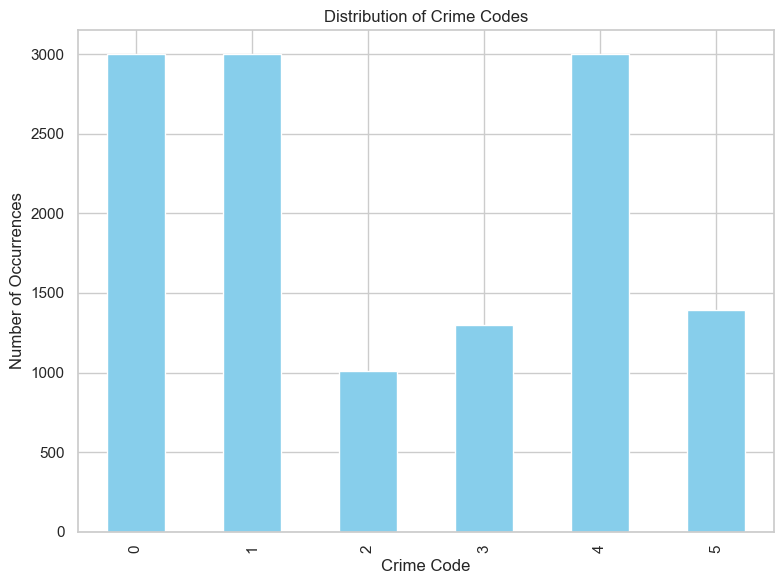

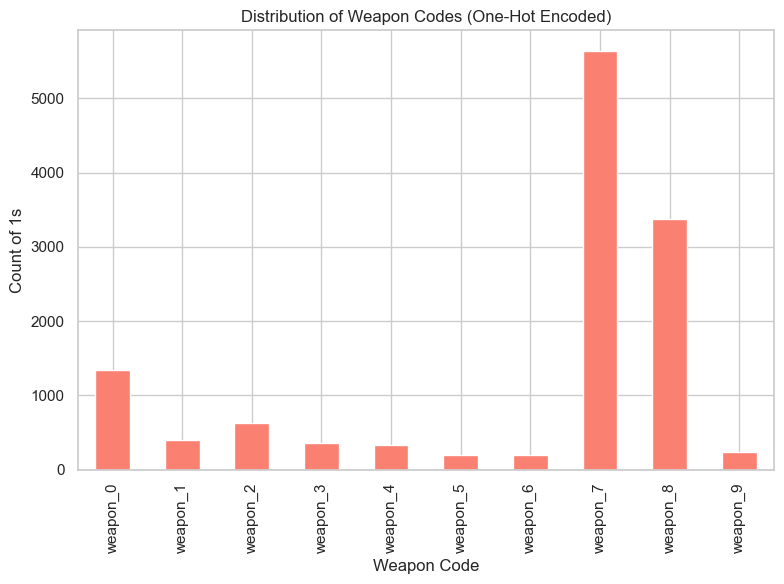

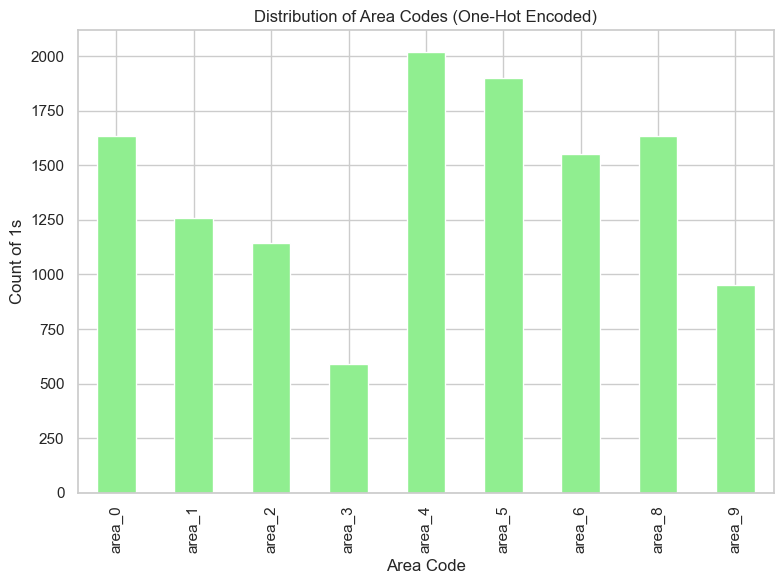

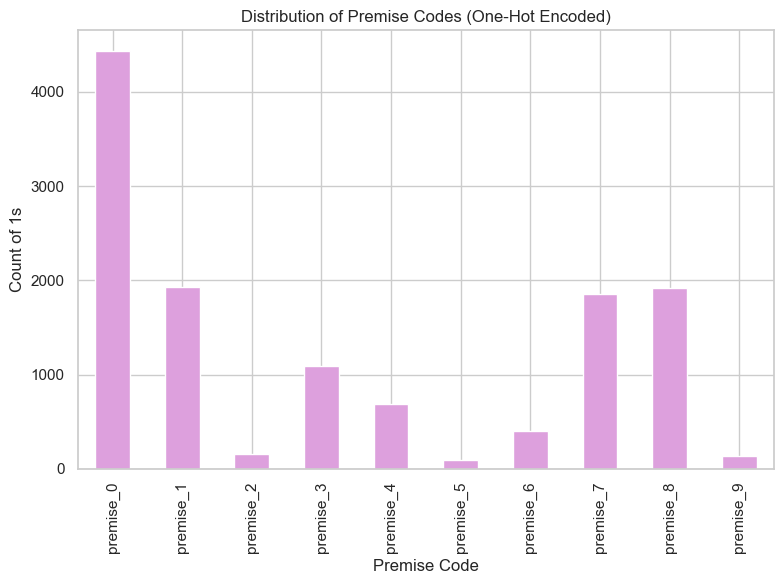

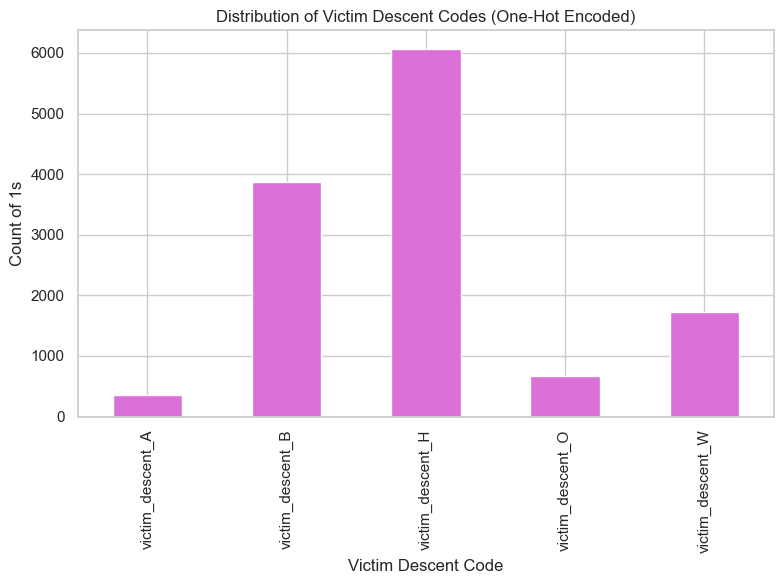

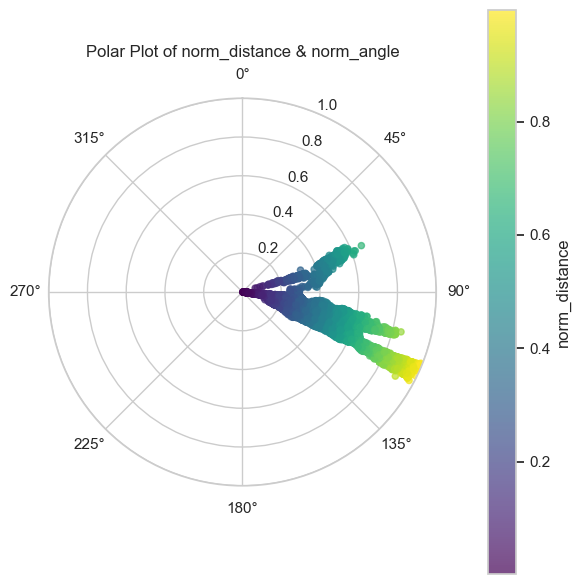

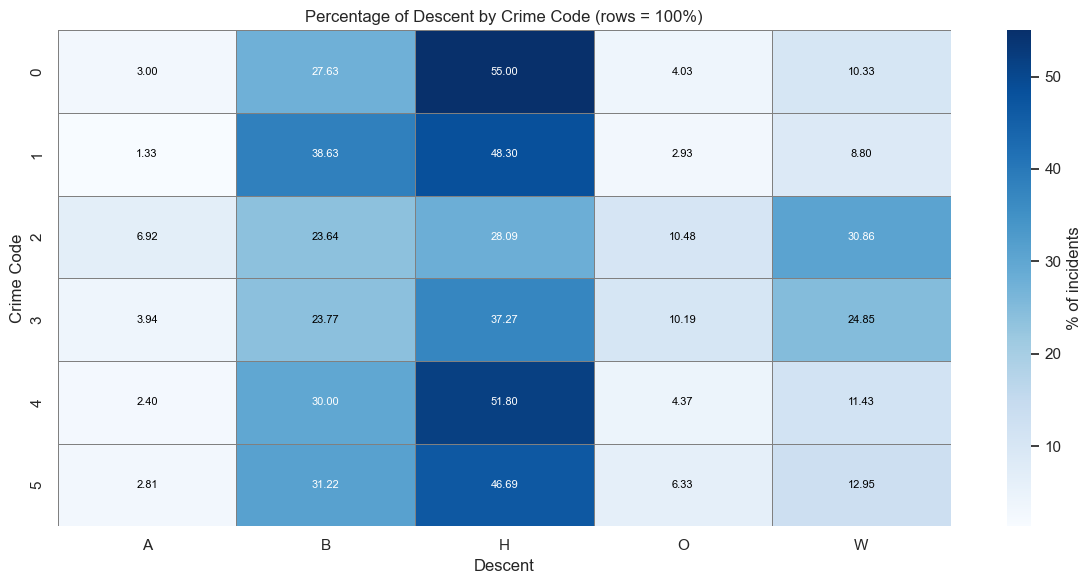

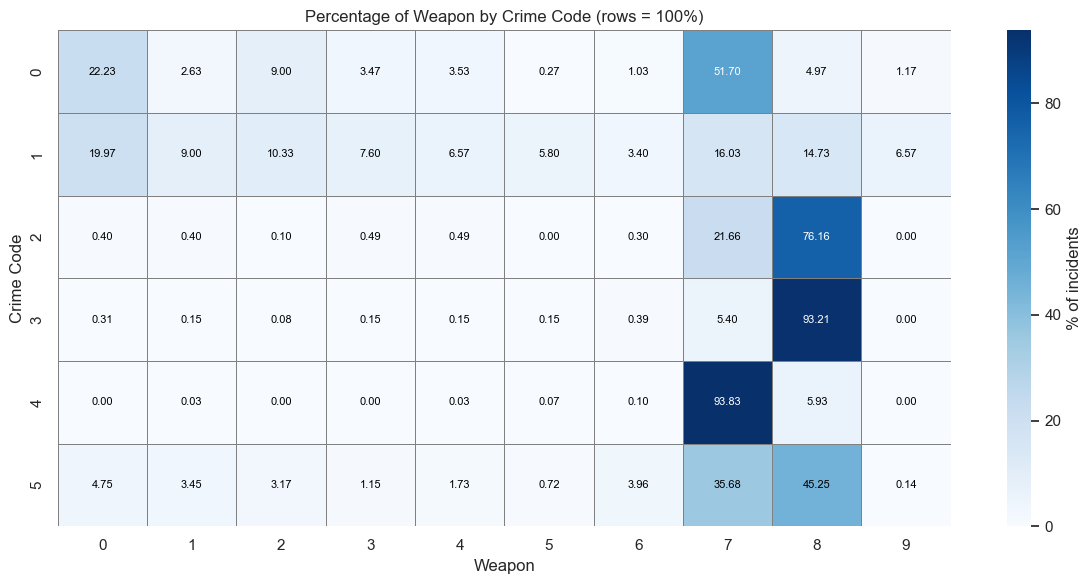

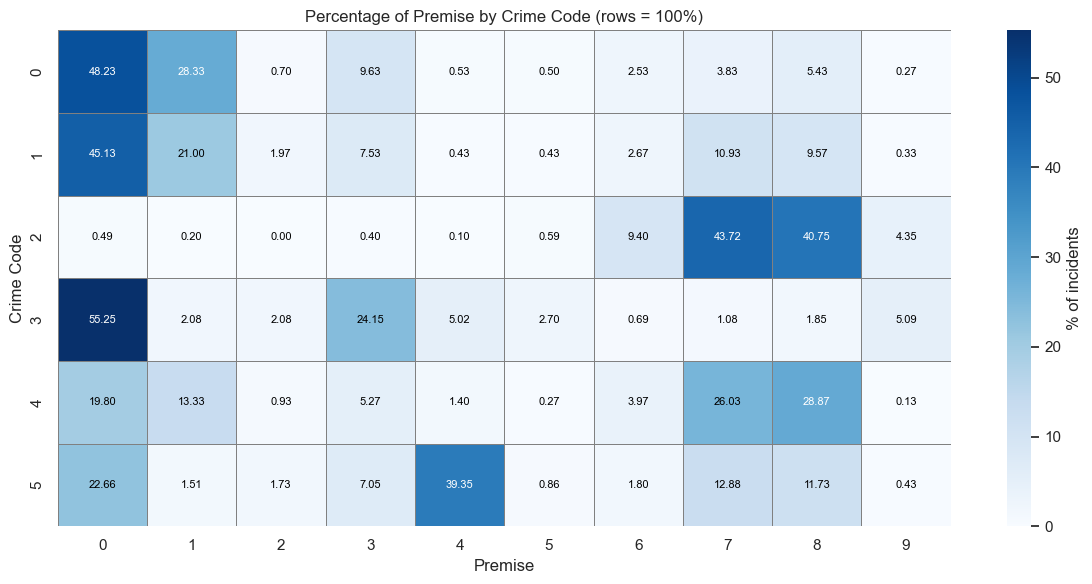

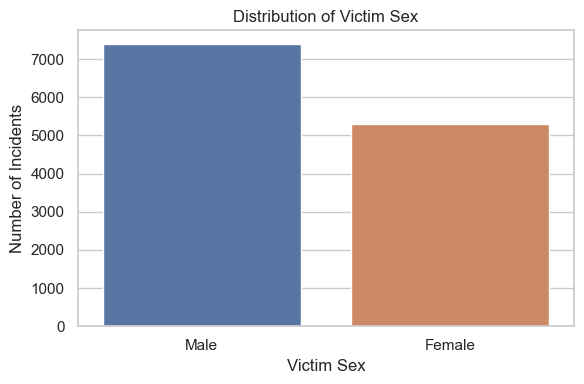

/var/folders/rh/33_81w2x1ylgctx63l7jvq280000gn/T/ipykernel_18686/3042831687.py:133: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


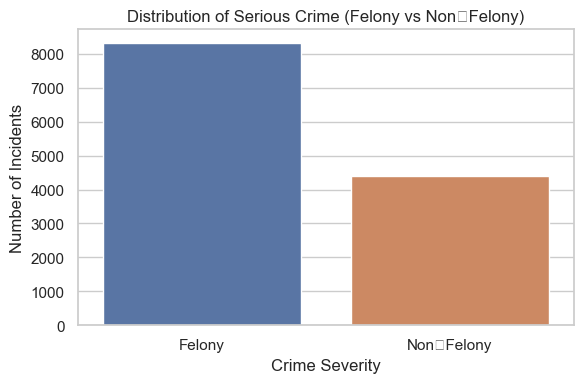

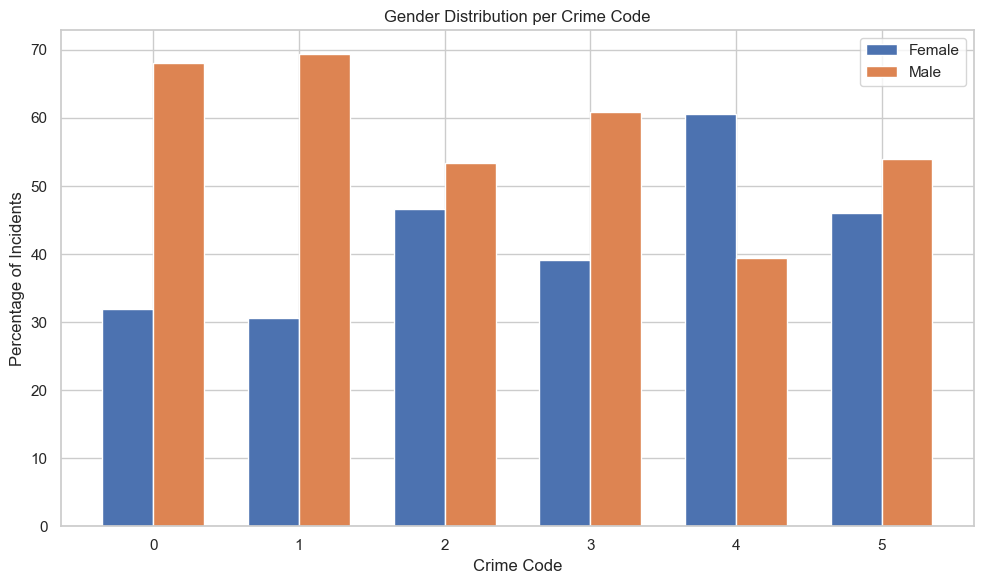

In [4]:
sns.set(style="whitegrid")

# Distribution of crime_code
crime_counts = df['crime_code'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
crime_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Crime Code")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Crime Codes")
plt.tight_layout()
plt.show()

# Distribution for weapon codes
weapon_cols = [col for col in df.columns if col.startswith("weapon_")]
weapon_counts = df[weapon_cols].sum().sort_index()
plt.figure(figsize=(8, 6))
weapon_counts.plot(kind='bar', color='salmon')
plt.xlabel("Weapon Code")
plt.ylabel("Count of 1s")
plt.title("Distribution of Weapon Codes (One-Hot Encoded)")
plt.tight_layout()
plt.show()

# Distribution for area codes
area_cols = [col for col in df.columns if col.startswith("area_")]
area_counts = df[area_cols].sum().sort_index()
plt.figure(figsize=(8, 6))
area_counts.plot(kind='bar', color='lightgreen')
plt.xlabel("Area Code")
plt.ylabel("Count of 1s")
plt.title("Distribution of Area Codes (One-Hot Encoded)")
plt.tight_layout()
plt.show()

# Distribution for premise codes
premise_cols = [col for col in df.columns if col.startswith("premise_")]
premise_counts = df[premise_cols].sum().sort_index()
plt.figure(figsize=(8, 6))
premise_counts.plot(kind='bar', color='plum')
plt.xlabel("Premise Code")
plt.ylabel("Count of 1s")
plt.title("Distribution of Premise Codes (One-Hot Encoded)")
plt.tight_layout()
plt.show()

# Distribution for victim descent codes
descent_cols = [col for col in df.columns if col.startswith("victim_descent_")]
descent_counts = df[descent_cols].sum().sort_index()
plt.figure(figsize=(8, 6))
descent_counts.plot(kind='bar', color='orchid')
plt.xlabel("Victim Descent Code")
plt.ylabel("Count of 1s")
plt.title("Distribution of Victim Descent Codes (One-Hot Encoded)")
plt.tight_layout()
plt.show()

# Polar plot of norm_distance & norm_angle
r = df['norm_distance']
theta = df['norm_angle'] * 2 * np.pi
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':'polar'})
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
sc = ax.scatter(theta, r, c=r, cmap='viridis', alpha=0.7, s=20)
ax.set_rlim(0, 1)
ax.set_title("Polar Plot of norm_distance & norm_angle", va='bottom')
plt.colorbar(sc, ax=ax, pad=0.1, label='norm_distance')
plt.tight_layout()
plt.show()

# Distributions for victim_descent, weapon, and premise vs crime_codes
prefixes = {
    'victim_descent_': 'Descent',
    'weapon_': 'Weapon',
    'premise_': 'Premise'
}

for prefix, label in prefixes.items():
    cols = [c for c in df.columns if c.startswith(prefix)]
    if not cols:
        continue
    cat_col = prefix.rstrip('_')
    df[cat_col] = (
        df[cols]
        .idxmax(axis=1)
        .str.replace(prefix, '', regex=False)
    )
    pct = (
        pd.crosstab(df['crime_code'], df[cat_col], normalize='index') 
        * 100
    ).round(2).fillna(0.0)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(
        pct, annot=False, fmt=".2f", cmap="Blues",
        cbar_kws={'label': '% of incidents'},
        linewidths=0.5, linecolor='gray',
        ax=ax
    )
    max_val = pct.values.max()
    for y in range(pct.shape[0]):
        for x in range(pct.shape[1]):
            val = pct.iat[y, x]
            text_color = 'white' if val > max_val/2 else 'black'
            ax.text(
                x + 0.5, y + 0.5, f"{val:.2f}",
                ha='center', va='center',
                color=text_color,
                fontsize=8
            )
    ax.set_title(f'Percentage of {label} by Crime Code (rows = 100%)')
    ax.set_xlabel(label)
    ax.set_ylabel('Crime Code')
    plt.tight_layout()
    plt.show()


# Distribution of victim sex and serious crime
df['victim_sex_label'] = df['victim_sex'].map({0: 'Female', 1: 'Male'})
df['serious_crime_label'] = df['serious_crime'].map({0: 'Non‑Felony', 1: 'Felony'})

plt.figure(figsize=(6, 4))
sns.countplot(x='victim_sex_label', data=df)
plt.title('Distribution of Victim Sex')
plt.ylabel('Number of Incidents')
plt.xlabel('Victim Sex')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='serious_crime_label', data=df)
plt.title('Distribution of Serious Crime (Felony vs Non‑Felony)')
plt.ylabel('Number of Incidents')
plt.xlabel('Crime Severity')
plt.tight_layout()
plt.show()

# Grouped bar chart for gender distribution by crime_code
pct_gender = pd.crosstab(df['crime_code'], df['victim_sex_label'], normalize='index') * 100
pct_gender = pct_gender.round(2)
codes = pct_gender.index.tolist()
female_pct = pct_gender['Female'].values
male_pct   = pct_gender['Male'].values
x = np.arange(len(codes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, female_pct, width, label='Female')
ax.bar(x + width/2, male_pct,   width, label='Male')
ax.set_xticks(x)
ax.set_xticklabels(codes)
ax.set_xlabel('Crime Code')
ax.set_ylabel('Percentage of Incidents')
ax.set_title('Gender Distribution per Crime Code')
ax.legend()
plt.tight_layout()
plt.show()


# Evaluate Model Function

In [5]:
def evaluate_model(eval_y, pred_y, model_name, best_params):
    # Read the crime mapping CSV to determine display labels.
    mapping_df = pd.read_csv("crime_mapping.csv")
    # Sort by crime code in case they are not ordered and get the list of labels.
    display_labels = mapping_df.sort_values("crime_code")["crime_code"].tolist()
    
    # Compute confusion matrix.
    cm = confusion_matrix(eval_y, pred_y)
    
    # Create and plot the confusion matrix with the labels from the CSV.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Reds)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()
    
    # Calculate overall metrics using weighted averaging.
    accuracy = accuracy_score(eval_y, pred_y)
    precision, recall, f1, _ = precision_recall_fscore_support(eval_y, pred_y, average='weighted')
    
    # Prepare a report string.
    report = (
        f"Model: {model_name}\n"
        f"Accuracy: {accuracy:.4f}\n"
        f"Precision (weighted): {precision:.4f}\n"
        f"Recall (weighted): {recall:.4f}\n"
        f"F1 Score (weighted): {f1:.4f}\n\n"
    )    
    print(report)

    if best_params is not None:
        print(f"Best Hyperparameters:\n{best_params}\n")
    
    return f1

# Split Data

In [6]:
# Split data into test and train.
df = pd.read_csv('cleaned_crime_data_stratified.csv')
display(df.head())
print(df.shape)

X = df.drop('crime_code', axis=1)
y = df['crime_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

,crime_code,victim_age,victim_sex,serious_crime,weapon_0,weapon_1,weapon_2,weapon_3,weapon_4,weapon_5,...,area_6,area_8,area_9,norm_distance,norm_angle,victim_descent_A,victim_descent_B,victim_descent_H,victim_descent_O,victim_descent_W
0,0,0.371134,1,1,0,0,0,0,0,0,...,0,0,0,0.313493,0.277640,0,0,1,0,0
1,0,0.340206,1,1,0,0,0,0,0,0,...,1,0,0,0.170160,0.292096,0,0,1,0,0
2,0,0.422680,1,1,1,0,0,0,0,0,...,0,1,0,0.150259,0.266166,0,0,1,0,0
3,0,0.432990,1,1,1,0,0,0,0,0,...,0,0,0,0.331765,0.316328,0,1,0,0,0
4,0,0.288660,0,1,0,0,0,0,0,0,...,0,1,0,0.261823,0.264902,0,1,0,0,0


(12697, 40)


# Train Models

Best hyperparameters: {'C': 1, 'class_weight': None, 'solver': 'lbfgs'}


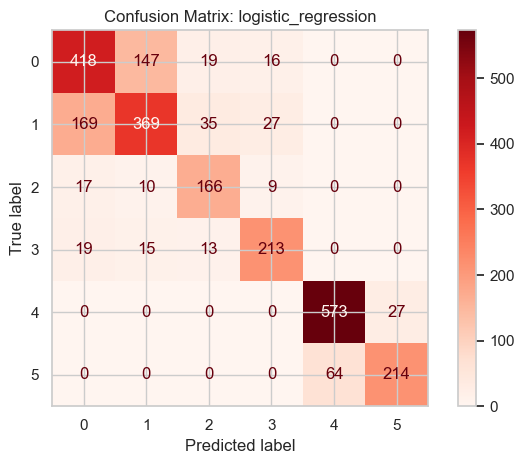

Model: logistic_regression
Accuracy: 0.7689
Precision (weighted): 0.7682
Recall (weighted): 0.7689
F1 Score (weighted): 0.7671


Best Hyperparameters:
{'C': 1, 'class_weight': None, 'solver': 'lbfgs'}



0.7671174775415446

In [7]:
def train_logistic_regression(train_x, train_y, test_x, test_y):
    model = LogisticRegression(max_iter=1000, random_state=42)
    
    # Define the grid of hyperparameters.
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'saga', 'newton-cg'],
        'class_weight': ['balanced', None] # Both support multinomial logistic regression.
    }
    
    # Set up GridSearchCV.
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(train_x, train_y)
    
    print("Best hyperparameters:", grid_search.best_params_)
    
    # Evaluate the model on the test set.
    y_pred = grid_search.predict(test_x)
    model_name = "logistic_regression"
    
    # Use the evaluation function to generate and save reports.
    return evaluate_model(
        test_y, y_pred, model_name, best_params=grid_search.best_params_
    )
    
train_logistic_regression(X_train, y_train, X_test, y_test)

### The model mistakes class 0 and class 1 frequently. Although not shown, we tried all of the models with the dataset as is and saw very little improvement. Thus, we thought we had to do some feature selection to try and improve performance. 

# Feature Selection

Number of features selected by backward elimination: 38


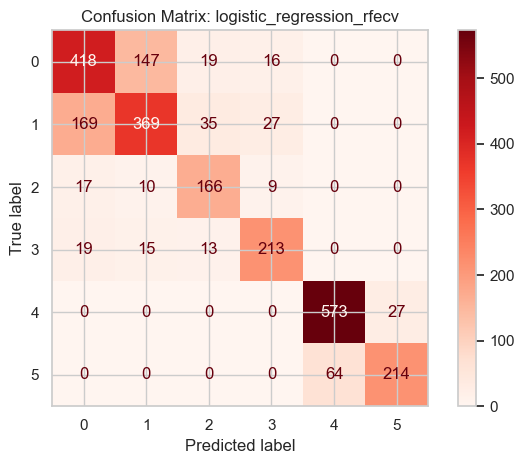

Model: logistic_regression_rfecv
Accuracy: 0.7689
Precision (weighted): 0.7682
Recall (weighted): 0.7689
F1 Score (weighted): 0.7671


Best Hyperparameters:
{'C': 1, 'class_weight': None, 'solver': 'lbfgs'}



In [8]:
# Initialize the base estimator for feature elimination.
base_estimator = LogisticRegression(max_iter=1000, random_state=42)

# Set up RFECV for backward elimination.
rfecv = RFECV(estimator=base_estimator, step=1, cv=5, scoring='f1_weighted')

# Set up the logistic regression model with the fixed hyperparameters.
logistic_regression = LogisticRegression(C=1, class_weight=None, solver='lbfgs', max_iter=1000, random_state=42)

# Create a pipeline: first perform backward feature elimination, then fit logistic regression.
pipeline = Pipeline([
    ('feature_selection', rfecv),
    ('logreg', logistic_regression)
])

# Fit the pipeline on the training data.
pipeline.fit(X_train, y_train)

# See how many features are selected.
selected_features = pipeline.named_steps['feature_selection'].n_features_
print(f"Number of features selected by backward elimination: {selected_features}")

# Evaluate the model on the test set.
y_pred = pipeline.predict(X_test)
model_name = "logistic_regression_rfecv"

# Use evaluation function to check performance
f1_score_weighted = evaluate_model(
    y_test, y_pred, model_name, best_params={'C': 1, 'class_weight': None, 'solver': 'lbfgs'}
)

### Tried logistic regression again with recursive feature elimination. It only eliminated two features out of 40 and the f1 was exactly the same. It seems like class 0 and class 1 are impossible to distinguish. We thought to explore their relationship further.

# Exploring Relationship Between Class 0 and Class 1

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


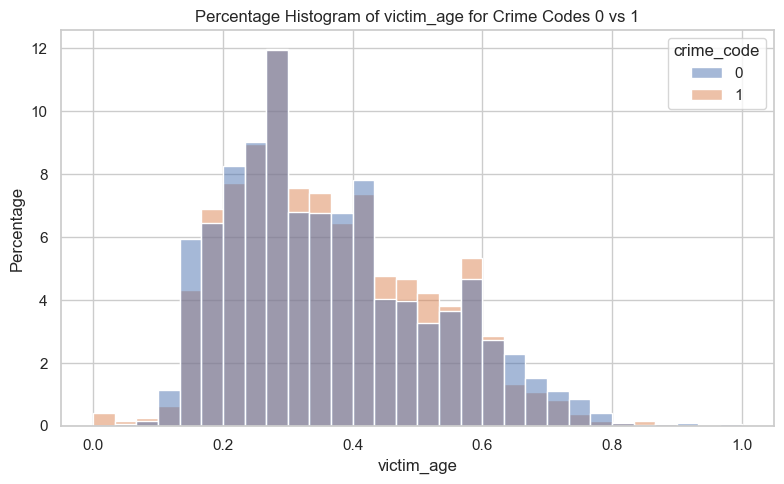

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


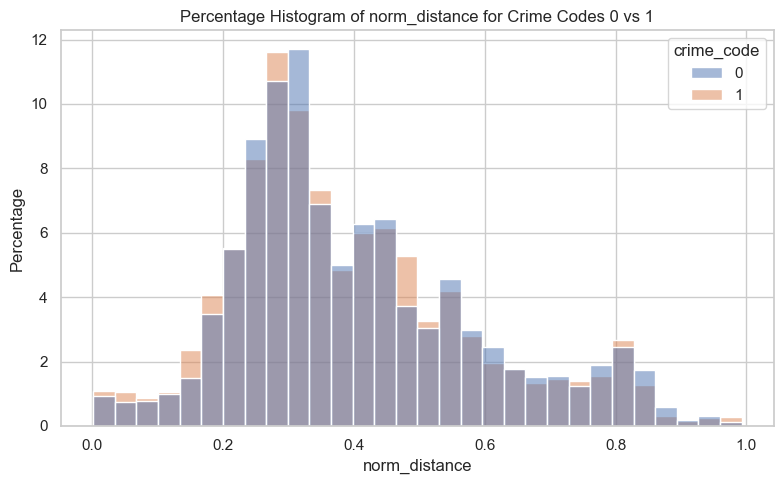

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


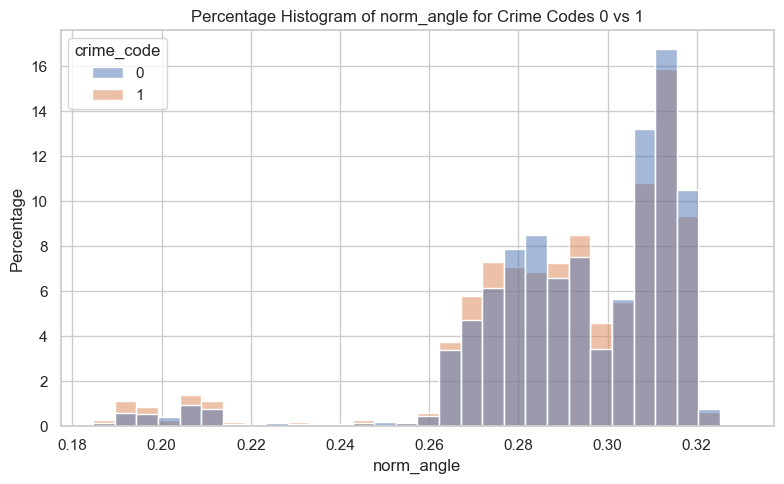

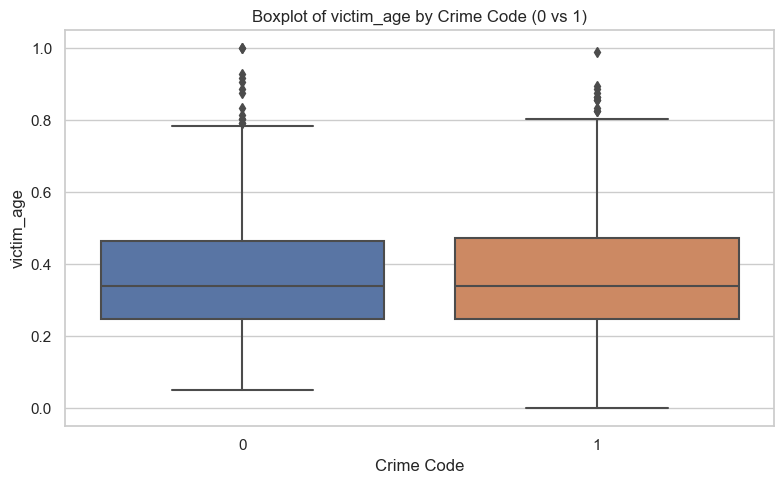

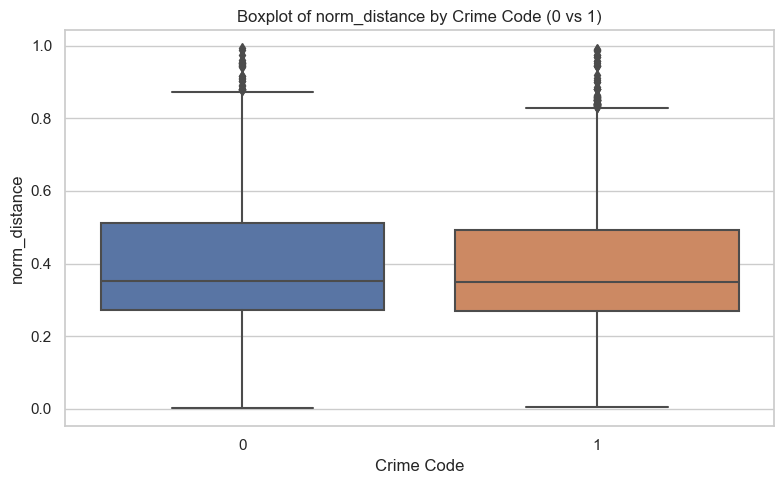

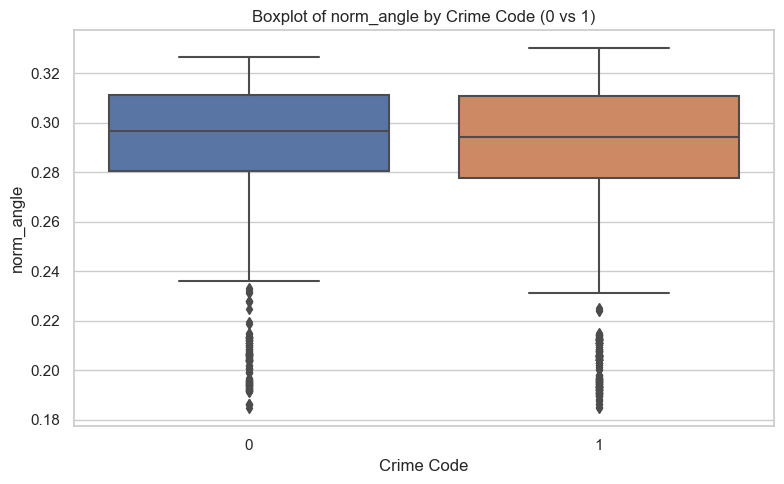

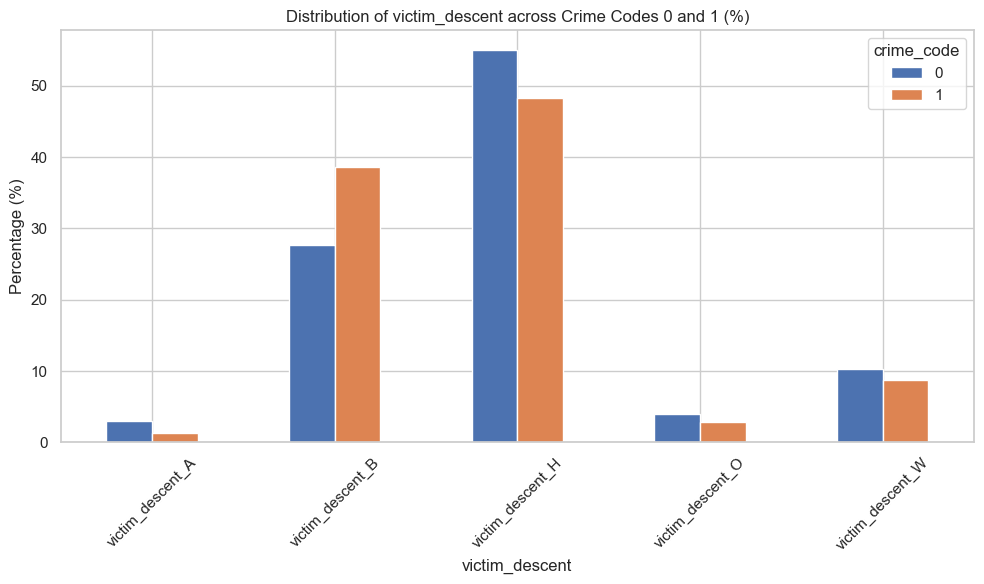

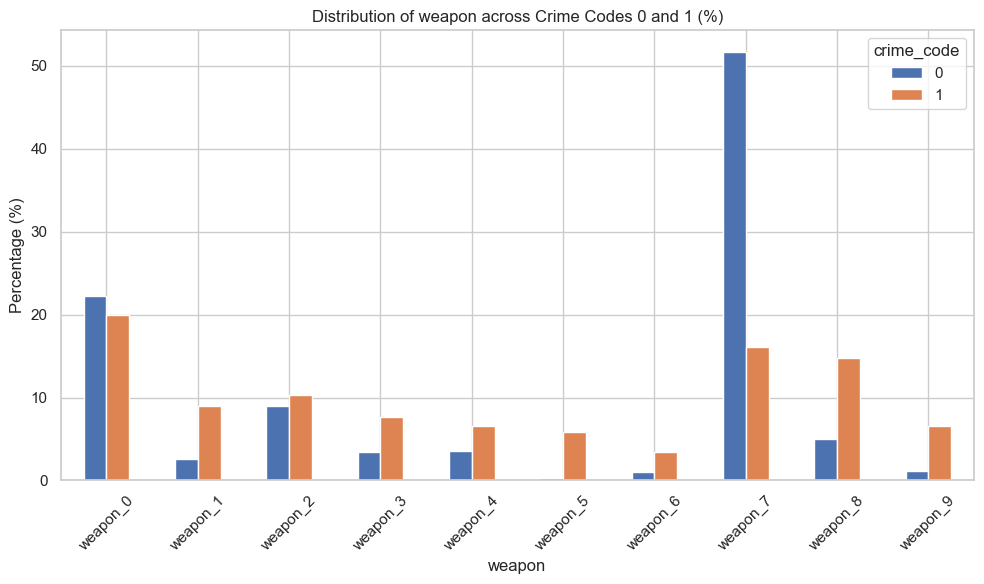

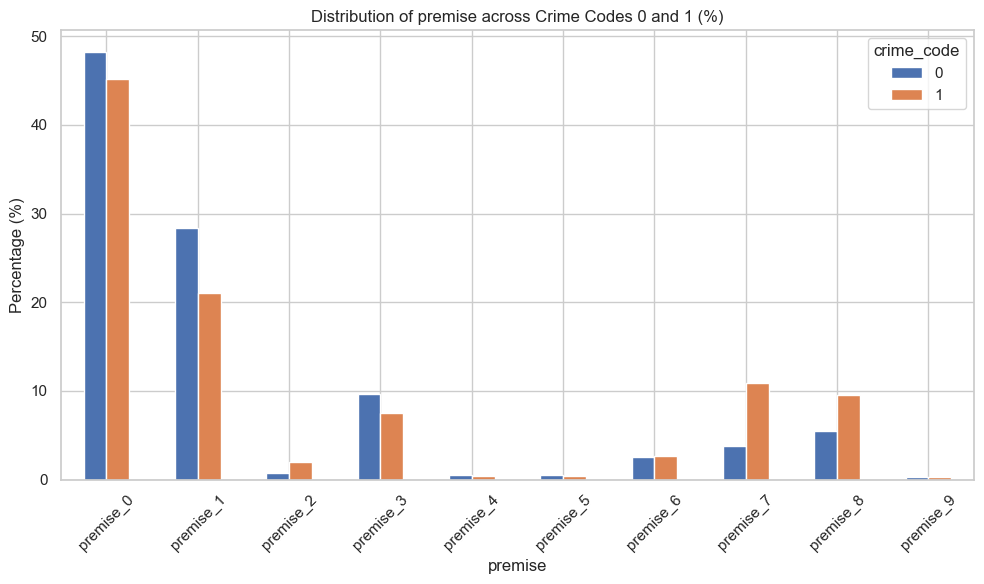

In [9]:
# Set plotting style.
sns.set(style="whitegrid")

# Subset of df for classes 0 and 1.
df_sub = df[df['crime_code'].isin([0, 1])]

numeric_features = ['victim_age', 'norm_distance', 'norm_angle']

# Histograms comparing numeric features.
for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df_sub, x=feature, hue="crime_code", stat="percent",
        common_norm=False, multiple="layer", bins=30
    )
    plt.title(f"Percentage Histogram of {feature} for Crime Codes 0 vs 1")
    plt.xlabel(feature)
    plt.ylabel("Percentage")
    plt.tight_layout()
    plt.show()
    plt.close()

# Boxplots comparing numeric features.
for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_sub, x="crime_code", y=feature)
    plt.title(f"Boxplot of {feature} by Crime Code (0 vs 1)")
    plt.xlabel("Crime Code")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()
    plt.close()

# Distribution of crimes 0 and 1 across categorical variables.
def show_categorical_distribution(prefix):
    cols = [c for c in df_sub.columns if c.startswith(prefix)]
    if not cols:
        print(f"No {prefix} one-hot columns found.")
        return
    counts = df_sub.groupby('crime_code')[cols].sum().T
    totals = df_sub.groupby('crime_code').size()
    pct = counts.divide(totals, axis=1) * 100
    pct.plot(kind='bar', figsize=(10, 6))
    plt.title(f"Distribution of {prefix.rstrip('_')} across Crime Codes 0 and 1 (%)")
    plt.xlabel(prefix.rstrip('_'))
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

show_categorical_distribution("victim_descent_")
show_categorical_distribution("weapon_")
show_categorical_distribution("premise_")

### The histograms and bar charts comparing the distributions of the continuous variables show the clear overlap. The distributions of the categorical variables are also similarly spread out. The only stand out difference is the weapon_7 distribution. Another slight difference is in the distribution of Black and Hispanic victims. However, it is easy to see why the models are getting confused with how similar they are. We decided to drop class 1 because its too similar. 

# Removing Class 1

In [10]:
df = pd.read_csv('cleaned_crime_data_stratified.csv')
df = df[df['crime_code'] != 1].copy()

# Remap codes above 1 → code - 1.
df.loc[df['crime_code'] > 1, 'crime_code'] -= 1

# Save new data.
df.to_csv('cleaned_crime_data_stratified.csv', index=False)

# Now update the mapping CSV the same way.
mapping = pd.read_csv('crime_mapping.csv')
mapping = mapping[mapping['crime_code'] != 1].copy()
mapping.loc[mapping['crime_code'] > 1, 'crime_code'] -= 1
mapping.to_csv('crime_mapping.csv', index=False)

In [11]:
# Split data into test and train again.
df = pd.read_csv('cleaned_crime_data_stratified.csv')
display(df.head())
print(df.shape)

X = df.drop('crime_code', axis=1)
y = df['crime_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

,crime_code,victim_age,victim_sex,serious_crime,weapon_0,weapon_1,weapon_2,weapon_3,weapon_4,weapon_5,...,area_6,area_8,area_9,norm_distance,norm_angle,victim_descent_A,victim_descent_B,victim_descent_H,victim_descent_O,victim_descent_W
0,0,0.371134,1,1,0,0,0,0,0,0,...,0,0,0,0.313493,0.277640,0,0,1,0,0
1,0,0.340206,1,1,0,0,0,0,0,0,...,1,0,0,0.170160,0.292096,0,0,1,0,0
2,0,0.422680,1,1,1,0,0,0,0,0,...,0,1,0,0.150259,0.266166,0,0,1,0,0
3,0,0.432990,1,1,1,0,0,0,0,0,...,0,0,0,0.331765,0.316328,0,1,0,0,0
4,0,0.288660,0,1,0,0,0,0,0,0,...,0,1,0,0.261823,0.264902,0,1,0,0,0


(9697, 40)


# Back To Model Training

Best hyperparameters: {'C': 1, 'class_weight': None, 'solver': 'lbfgs'}


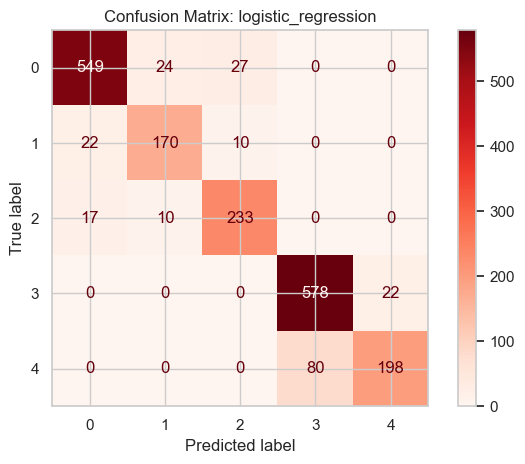

Model: logistic_regression
Accuracy: 0.8907
Precision (weighted): 0.8918
Recall (weighted): 0.8907
F1 Score (weighted): 0.8890


Best Hyperparameters:
{'C': 1, 'class_weight': None, 'solver': 'lbfgs'}



In [12]:
# Redo logistic regression

# Store f1 scores for comparison
f1_scores = []

f1_scores.append(["logistic_regression", train_logistic_regression(X_train, y_train, X_test, y_test)])

Best hyperparameters: {'logreg__C': 0.1, 'poly__degree': 3}


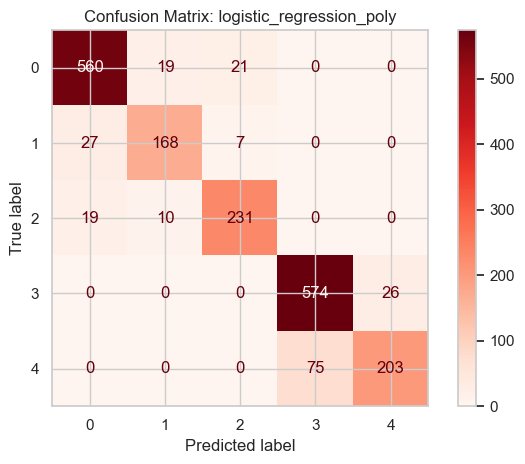

Model: logistic_regression_poly
Accuracy: 0.8948
Precision (weighted): 0.8947
Recall (weighted): 0.8948
F1 Score (weighted): 0.8932


Best Hyperparameters:
{'logreg__C': 0.1, 'poly__degree': 3}



In [13]:
def train_poly_logistic_regression(train_x, train_y, test_x, test_y):
    # Initalize the pipeline for polynomial logistic regression.
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Define the grid of hyperparameters.
    param_grid = {
        'poly__degree': [2, 3],
        'logreg__C': [0.0001, 0.0003, 0.001, 0.1, 1],
    }
    
    # Set up GridSearchCV using the pipeline.
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(train_x, train_y)
    
    print("Best hyperparameters:", grid_search.best_params_)
    
    # Evaluate the best model on the test set.
    y_pred = grid_search.predict(test_x)
    model_name = "logistic_regression_poly"
    
    # Use the evaluation function to generate and save performance reports.
    return evaluate_model(
        test_y, y_pred, model_name, best_params=grid_search.best_params_
    )
    

f1_scores.append(["Polynomial Logistic Regression", train_poly_logistic_regression(X_train, y_train, X_test, y_test)])

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 10}


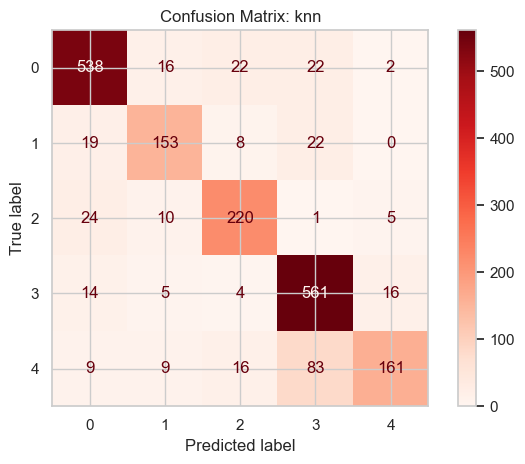

Model: knn
Accuracy: 0.8418
Precision (weighted): 0.8444
Recall (weighted): 0.8418
F1 Score (weighted): 0.8374


Best Hyperparameters:
{'metric': 'euclidean', 'n_neighbors': 10}



In [14]:
def train_knn(train_x, train_y, test_x, test_y):
    # Define the KNN classifier.
    model = KNeighborsClassifier()
    
    # Define the parameter grid for GridSearchCV.
    param_grid = {
        'n_neighbors': [5, 10, 15, 20],
        'metric': ['euclidean']
    }
    
    # Set up GridSearchCV.
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=1)
    grid_search.fit(train_x, train_y)
    
    print("Best hyperparameters:", grid_search.best_params_)
    
    # Evaluate the model on the test set.
    y_pred = grid_search.predict(test_x)
    model_name = "knn"
    
    # Use the evaluation function to generate and save performance reports.
    return evaluate_model(
        test_y, y_pred, model_name, best_params=grid_search.best_params_
    )

f1_scores.append(["KNN", train_knn(X_train, y_train, X_test, y_test)])

Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


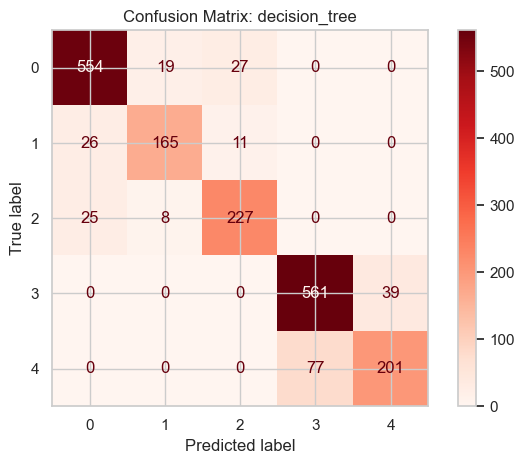

Model: decision_tree
Accuracy: 0.8804
Precision (weighted): 0.8795
Recall (weighted): 0.8804
F1 Score (weighted): 0.8790


Best Hyperparameters:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}



In [15]:
def train_decision_tree(train_x, train_y, test_x, test_y):
    # Define the Decision Tree classifier.
    model = DecisionTreeClassifier(random_state=42)
    
    # Define the parameter grid for GridSearchCV.
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Set up GridSearchCV.
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(train_x, train_y)
    
    print("Best hyperparameters:", grid_search.best_params_)
    
    # Evaluate the model on the test set.
    y_pred = grid_search.predict(test_x)
    model_name = "decision_tree"
    
    # Use the evaluation function to generate and save performance reports.
    return evaluate_model(
        test_y, y_pred, model_name, best_params=grid_search.best_params_
    )

f1_scores.append(["Decision Tree", train_decision_tree(X_train, y_train, X_test, y_test)])

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}


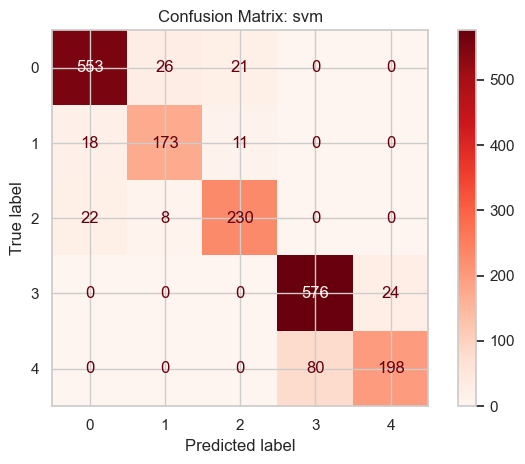

Model: svm
Accuracy: 0.8918
Precision (weighted): 0.8925
Recall (weighted): 0.8918
F1 Score (weighted): 0.8901


Best Hyperparameters:
{'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}



In [16]:
def train_svm(train_x, train_y, test_x, test_y):
    # Initialize the SVM model
    model = SVC(random_state=42)
    
    # Define hyperparameter grid
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced', None]
    }
    
    # Grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(train_x, train_y)
    
    print("Best hyperparameters:", grid_search.best_params_)
    
    # Predictions and evaluation
    y_pred = grid_search.predict(test_x)
    model_name = "svm"
    
    return evaluate_model(
        test_y, y_pred, model_name, best_params=grid_search.best_params_
    )


f1_scores.append(["SVM", train_svm(X_train, y_train, X_test, y_test)])

# Ensemble Methods

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


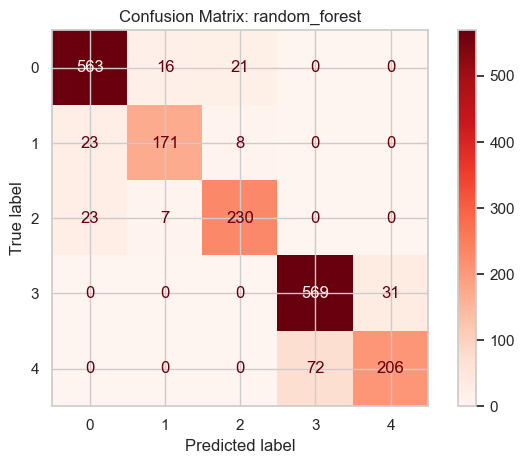

Model: random_forest
Accuracy: 0.8964
Precision (weighted): 0.8958
Recall (weighted): 0.8964
F1 Score (weighted): 0.8950


Best Hyperparameters:
{'class_weight': None, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}



In [17]:
def train_random_forest(train_x, train_y, test_x, test_y):
    # Define model and grid search params
    model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced', None]
    }
    
    # Run grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(train_x, train_y)
    
    # Predict
    y_pred = grid_search.predict(test_x)
    
    model_name = "random_forest"
    
    return evaluate_model(
        test_y, y_pred, model_name, best_params=grid_search.best_params_
    )

f1_scores.append(["Random Forest", train_random_forest(X_train, y_train, X_test, y_test)])

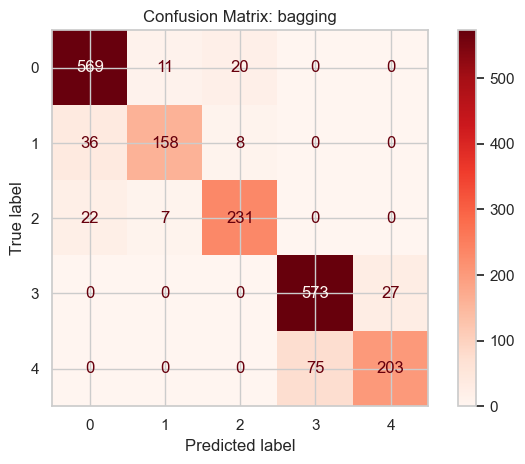

Model: bagging
Accuracy: 0.8938
Precision (weighted): 0.8936
Recall (weighted): 0.8938
F1 Score (weighted): 0.8917


Best Hyperparameters:
{'estimator__max_depth': 10, 'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 100}



In [18]:
def train_bagging(train_x, train_y, test_x, test_y):
    # Define model and grid search params
    base_estimator = DecisionTreeClassifier(random_state=42)
    model = BaggingClassifier(
        estimator=base_estimator,
        random_state=42
    )
    
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0],
        'estimator__max_depth': [5, 10, None]
    }
    
    # Run grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(train_x, train_y)
    
    # Predict
    y_pred = grid_search.predict(test_x)
    
    model_name = "bagging"
    
    return evaluate_model(
        test_y, y_pred, model_name, best_params=grid_search.best_params_
    )

f1_scores.append(["Bagging", train_bagging(X_train, y_train, X_test, y_test)])

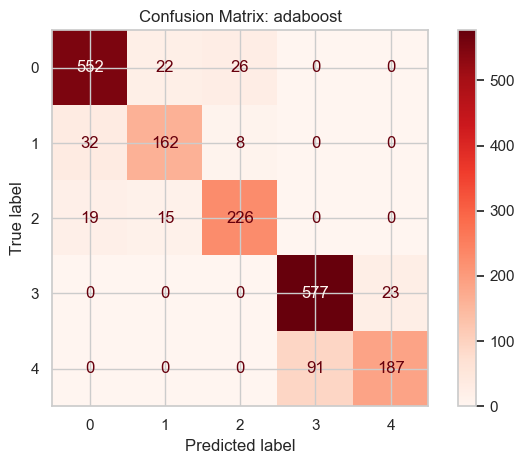

Model: adaboost
Accuracy: 0.8784
Precision (weighted): 0.8791
Recall (weighted): 0.8784
F1 Score (weighted): 0.8757


Best Hyperparameters:
{'learning_rate': 0.1, 'n_estimators': 500}



In [19]:
def train_adaboost(train_x, train_y, test_x, test_y):
    # Define model and grid search params
    base_estimator = DecisionTreeClassifier(max_depth=1)

    # Create the AdaBoost classifier with the specified base estimator.
    model = AdaBoostClassifier(estimator=base_estimator, random_state=42)
    
    # Define the parameter grid to search through.
    param_grid = {
        'n_estimators': [50, 100, 200, 500, 1000],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
    }
    
    # Run grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(train_x, train_y)
    
    # Predict
    y_pred = grid_search.predict(test_x)
    
    model_name = "adaboost"
    
    return evaluate_model(
        test_y, y_pred, model_name, best_params=grid_search.best_params_
    )

f1_scores.append(["AdaBoost", train_adaboost(X_train, y_train, X_test, y_test)])

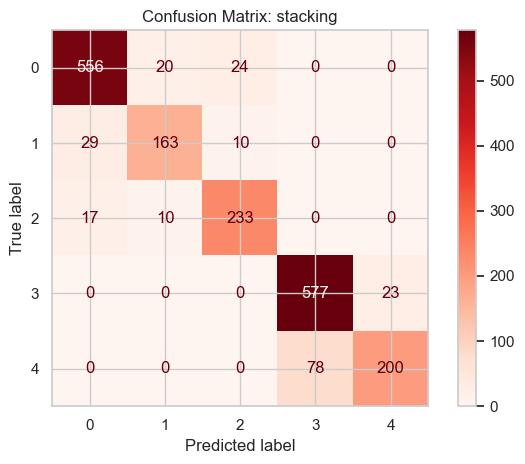

Model: stacking
Accuracy: 0.8912
Precision (weighted): 0.8915
Recall (weighted): 0.8912
F1 Score (weighted): 0.8894




In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier


def train_stacking(train_x, train_y, test_x, test_y):
    # Defining base learners.
    base_learners = [
        ('lr', LogisticRegression(max_iter=1000, C=1.0)),
        ('dt', DecisionTreeClassifier(max_depth=10, random_state=42)),
        ('svm', SVC(C=1.0, kernel='linear', probability=True, random_state=42)), 
        ('knn', KNeighborsClassifier(n_neighbors=10))
    ]
    
    # Defining meta learner.
    meta_learner = LogisticRegression(C=1.0, max_iter=1000)
    
    # Build stacking classifier.
    stack_clf = StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_learner,
        cv=5,
        passthrough=False,
        n_jobs=-1
    )
    
    # Fit to training data.
    stack_clf.fit(train_x, train_y)

    # Predict on test set.
    y_pred = stack_clf.predict(test_x)
    
    # Evaluate model performance.
    model_name = "stacking"
    return evaluate_model(test_y, y_pred, model_name, None)

f1_scores.append(["Stacking", train_stacking(X_train, y_train, X_test, y_test)])

# Neural Networks

Epoch 1/300


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.7933 - loss: 0.5959 - val_accuracy: 0.8943 - val_loss: 0.2992
Epoch 2/300
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.8884 - loss: 0.3086 - val_accuracy: 0.8872 - val_loss: 0.2896
Epoch 3/300
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.8973 - loss: 0.2828 - val_accuracy: 0.8937 - val_loss: 0.3005
Epoch 4/300
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - accuracy: 0.8958 - loss: 0.2808 - val_accuracy: 0.8898 - val_loss: 0.3006
Epoch 5/300
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - accuracy: 0.9064 - loss: 0.2474 - val_accuracy: 0.8905 - val_loss: 0.2922
Epoch 6/300
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.8984 - loss: 0.2652 - val_accuracy: 0.8892 - val_loss: 0.3073
Epoch 7/300
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - accuracy: 0.8998 - loss: 0.2565 - val_accuracy: 0.8860 - val_loss: 0.3124
Epoch 8/300
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.9051 - loss: 0.2491 - val_

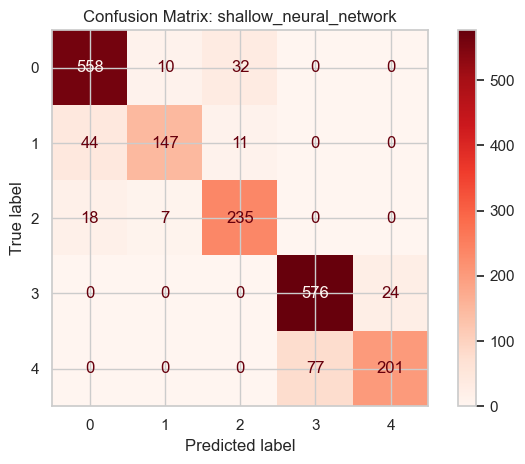

Model: shallow_neural_network
Accuracy: 0.8851
Precision (weighted): 0.8858
Recall (weighted): 0.8851
F1 Score (weighted): 0.8825




In [21]:
def train_shallow_neural_network(train_x, train_y, test_x, test_y):
    unique_labels = np.unique(np.concatenate([train_y, test_y]))
    n_features = train_x.shape[1]
    n_classes  = len(unique_labels)

    model = Sequential([
        Dense(100, activation='relu', input_shape=(n_features,)),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model.fit(
        train_x, y_train,
        validation_split=0.2,
        epochs=300,
        batch_size=32,
        callbacks=[early_stop]
    )

    y_pred_probs   = model.predict(test_x)
    y_pred  = np.argmax(y_pred_probs, axis=1)

    f1_score_weighted = evaluate_model(
        test_y, 
        y_pred, 
        model_name="shallow_neural_network", 
        best_params=None
    )

    return f1_score_weighted

f1_scores.append(["Shallow Neural Network", train_shallow_neural_network(X_train, y_train, X_test, y_test)])

Epoch 1/300


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 - 1s - 3ms/step - accuracy: 0.8561 - loss: 0.3984 - val_accuracy: 0.8853 - val_loss: 0.3057
Epoch 2/300
194/194 - 0s - 508us/step - accuracy: 0.8880 - loss: 0.2992 - val_accuracy: 0.8814 - val_loss: 0.3142
Epoch 3/300
194/194 - 0s - 492us/step - accuracy: 0.8888 - loss: 0.2933 - val_accuracy: 0.8834 - val_loss: 0.3118
Epoch 4/300
194/194 - 0s - 495us/step - accuracy: 0.8902 - loss: 0.2887 - val_accuracy: 0.8885 - val_loss: 0.2869
Epoch 5/300
194/194 - 0s - 488us/step - accuracy: 0.8935 - loss: 0.2753 - val_accuracy: 0.8879 - val_loss: 0.3035
Epoch 6/300
194/194 - 0s - 491us/step - accuracy: 0.8948 - loss: 0.2754 - val_accuracy: 0.8898 - val_loss: 0.3021
Epoch 7/300
194/194 - 0s - 508us/step - accuracy: 0.8938 - loss: 0.2814 - val_accuracy: 0.8866 - val_loss: 0.3070
Epoch 8/300
194/194 - 0s - 524us/step - accuracy: 0.8981 - loss: 0.2607 - val_accuracy: 0.8866 - val_loss: 0.3418
Epoch 9/300
194/194 - 0s - 498us/step - accuracy: 0.8956 - loss: 0.2754 - val_accuracy: 0.8827 - val_l

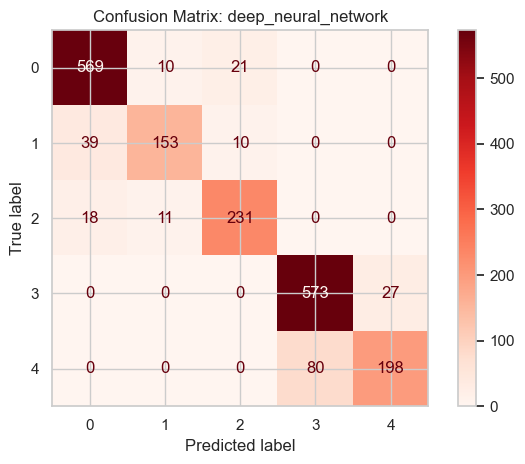

Model: deep_neural_network
Accuracy: 0.8887
Precision (weighted): 0.8883
Recall (weighted): 0.8887
F1 Score (weighted): 0.8861




In [22]:
def train_deep_neural_network(train_x, train_y, test_x, test_y):
    unique_labels = np.unique(np.concatenate([train_y, test_y]))
    n_features = train_x.shape[1]
    n_classes  = len(unique_labels)

    model = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        train_x, train_y,
        validation_split=0.2,
        epochs=300,
        batch_size=32,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_probs = model.predict(test_x)
    y_pred       = np.argmax(y_pred_probs, axis=1)

    f1_score_weighted = evaluate_model(
        test_y, 
        y_pred, 
        model_name="deep_neural_network", 
        best_params=None
    )

    return f1_score_weighted

f1_scores.append(["Deep Neural Network", train_deep_neural_network(X_train, y_train, X_test, y_test)])

Epoch 1/300


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 - 1s - 3ms/step - accuracy: 0.8271 - loss: 0.4702 - val_accuracy: 0.8782 - val_loss: 0.3387
Epoch 2/300
194/194 - 0s - 560us/step - accuracy: 0.8796 - loss: 0.3457 - val_accuracy: 0.8905 - val_loss: 0.3060
Epoch 3/300
194/194 - 0s - 544us/step - accuracy: 0.8785 - loss: 0.3409 - val_accuracy: 0.8924 - val_loss: 0.2994
Epoch 4/300
194/194 - 0s - 540us/step - accuracy: 0.8848 - loss: 0.3205 - val_accuracy: 0.8905 - val_loss: 0.3032
Epoch 5/300
194/194 - 0s - 542us/step - accuracy: 0.8883 - loss: 0.3095 - val_accuracy: 0.8866 - val_loss: 0.3370
Epoch 6/300
194/194 - 0s - 551us/step - accuracy: 0.8815 - loss: 0.3255 - val_accuracy: 0.8911 - val_loss: 0.3013
Epoch 7/300
194/194 - 0s - 567us/step - accuracy: 0.8882 - loss: 0.3050 - val_accuracy: 0.8872 - val_loss: 0.3111
Epoch 8/300
194/194 - 0s - 632us/step - accuracy: 0.8883 - loss: 0.3119 - val_accuracy: 0.8879 - val_loss: 0.3352
Epoch 9/300
194/194 - 0s - 615us/step - accuracy: 0.8835 - loss: 0.3147 - val_accuracy: 0.8834 - val_l

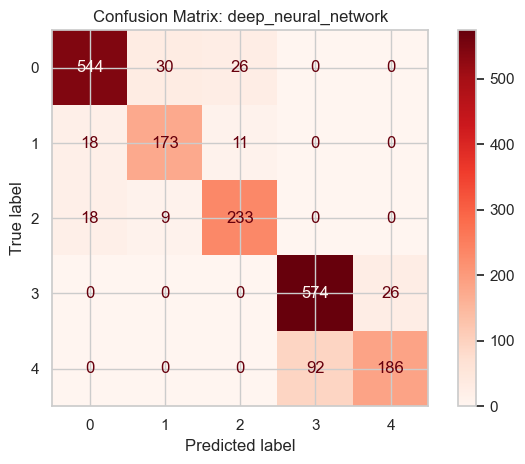

Model: deep_neural_network
Accuracy: 0.8814
Precision (weighted): 0.8830
Recall (weighted): 0.8814
F1 Score (weighted): 0.8793




In [23]:
def train_deep_neural_network_with_dropout(train_x, train_y, test_x, test_y):
    unique_labels = np.unique(np.concatenate([train_y, test_y]))
    n_features = train_x.shape[1]
    n_classes  = len(unique_labels)

    model = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        train_x, train_y,
        validation_split=0.2,
        epochs=300,
        batch_size=32,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_probs = model.predict(test_x)
    y_pred       = np.argmax(y_pred_probs, axis=1)

    f1_score_weighted = evaluate_model(
        test_y, 
        y_pred, 
        model_name="deep_neural_network", 
        best_params=None
    )

    return f1_score_weighted

f1_scores.append(["Deep Neural Network w/ Dropout",train_deep_neural_network_with_dropout(X_train, y_train, X_test, y_test)])

# Results

In [24]:
for model_name, f1_score in f1_scores:
    print(model_name + ": " + str(f1_score))

logistic_regression: 0.8890326711453205
Polynomial Logistic Regression: 0.8932292755401413
KNN: 0.8374075540466175
Decision Tree: 0.8789961968283658
SVM: 0.8900737587448279
Random Forest: 0.8950041694964673
Bagging: 0.8917189020621559
AdaBoost: 0.8757472014715911
Stacking: 0.8893624524912308
Shallow Neural Network: 0.8825089177484005
Deep Neural Network: 0.8861172511908044
Deep Neural Network w/ Dropout: 0.8792650820695772
